##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [236]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
from IPython.display import clear_output
from numpy import savetxt
from numpy import loadtxt
import matplotlib.pyplot as plt 

##  <font color=MediumSlateBlue>Directions</font> ##

In [237]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

##  <font color=MediumSlateBlue>Environment</font> ##

In [238]:
class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 1.0 if is_done(s) else 0.0
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

##  <font color=MediumSlateBlue>Reseting Model</font> ##

In [239]:
env=GridworldEnv()
env.reset() 
env._render()

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  


##  <font color=MediumSlateBlue>Training Model</font> ## 

In [240]:
def training_model(gamma,Learning_rate,exploration_probability,episode):
    Numer_of_states=10*10*1
    Number_of_action=4
    Q_Matrix = loadtxt('Q_func_init.csv', delimiter=',')
    path_length_episode = []
    rewards_per_episode = []
    for i in range(episode):
        state = env.reset()
        move=0
        reward=0
        done = False
        total_episode_reward = 0
        while not done:
            if random.uniform(0, 1) < exploration_probability:
                action = env.action_space.sample() 
            else:
                action = np.argmax(Q_Matrix[state]) 
            
            next_state, reward, done, info = env.step(action)
            if reward == -10 :
                next_state=44    
            previous_value = Q_Matrix[state, action]
            next_max = np.max(Q_Matrix[next_state])
            #reward=reward-1
            new_value = (1 - Learning_rate) * previous_value + Learning_rate * (reward + gamma * next_max)
            Q_Matrix[state, action] = new_value  
            total_episode_reward = total_episode_reward + reward
            state = next_state
            move += 1
        rewards_per_episode.append(total_episode_reward)
        path_length_episode.append(move)  
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")    
    print("Training succesfully finished.\n")
    savetxt('Q_func.csv',Q_Matrix, delimiter=',')
    
    return path_length_episode,rewards_per_episode,Q_Matrix

In [241]:
%%time
Learning_rate = 0.1
gamma = 0.99
exploration_probability = 0.1

path_length_episode,rewards_per_episode,Q_Matrix=training_model(gamma,Learning_rate,exploration_probability,20000)

Episode: 19900
Training succesfully finished.

Wall time: 7.35 s


Text(0.5, 0, 'iteration')

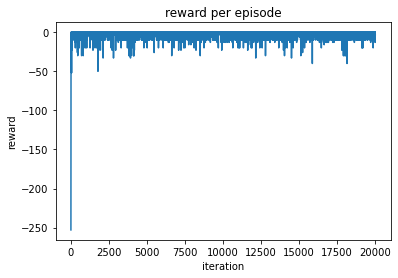

In [242]:
plt.plot(rewards_per_episode)
plt.title('reward per episode')
plt.ylabel('reward')
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

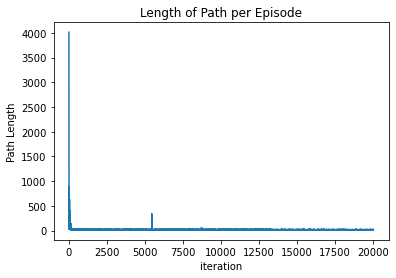

In [243]:
plt.plot(path_length_episode)
plt.title('Length of Path per Episode')
plt.ylabel('Path Length')
plt.xlabel('iteration')

##  <font color=MediumSlateBlue>Testing Model After Q-Learning</font> ##

In [244]:
episodes = 5
for _ in range(episodes):    
    state = env.reset()
    move=0
    penalties=0
    reward = 0
    done = False
    while not done:
        action = np.argmax(Q_Matrix[state])
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        if reward == -3:
            penalties += 1
        move += 1
    env._render()    
    print(f"Results after {episodes} episodes:")
    print(f"Path Length: {move}")
    print(f"Number of Penalty: {penalties}")

  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
Results after 5 episodes:
Path Length: 12
Number of Penalty: 0
  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .   

# Bonus

## First Idea

In [245]:
def training_model(gamma,Learning_rate,exploration_probability,episode):
    Numer_of_states=10*10*1
    Number_of_action=4
    Q_Matrix = loadtxt('Q_func_init.csv', delimiter=',')
    path_length_episode = []
    rewards_per_episode = []
    for i in range(episode):
        state = env.reset()
        move=0
        reward=0
        done = False
        total_episode_reward = 0
        while not done:
            if random.uniform(0, 1) < exploration_probability:
                action = env.action_space.sample() 
            else:
                action = np.argmax(Q_Matrix[state]) 
            
            next_state, reward, done, info = env.step(action)
            if reward == -10 :
                next_state=44    
            previous_value = Q_Matrix[state, action]
            next_max = np.max(Q_Matrix[next_state])
            reward=reward-1
            new_value = (1 - Learning_rate) * previous_value + Learning_rate * (reward + gamma * next_max)
            Q_Matrix[state, action] = new_value  
            total_episode_reward = total_episode_reward + reward
            state = next_state
            move += 1
        rewards_per_episode.append(total_episode_reward)
        path_length_episode.append(move)  
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")    
    print("Training succesfully finished.\n")
    savetxt('Q_func.csv',Q_Matrix, delimiter=',')
    
    return path_length_episode,rewards_per_episode,Q_Matrix

In [246]:
path_length_episode,rewards_per_episode,Q_Matrix=training_model(gamma,Learning_rate,exploration_probability,1000)
episodes = 5
for _ in range(episodes):    
    state = env.reset()
    move=0
    penalties=0
    reward = 0
    done = False
    while not done:
        action = np.argmax(Q_Matrix[state])
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        if reward == -3:
            penalties += 1
        move += 1
    env._render()    
    print(f"Results after {episodes} episodes:")
    print(f"Path Length: {move}")
    print(f"Number of Penalty: {penalties}")

Episode: 900
Training succesfully finished.

  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
Results after 5 episodes:
Path Length: 12
Number of Penalty: 0
  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    

Text(0.5, 0, 'iteration')

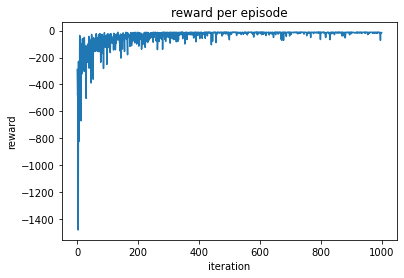

In [247]:
plt.plot(rewards_per_episode)
plt.title('reward per episode')
plt.ylabel('reward')
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

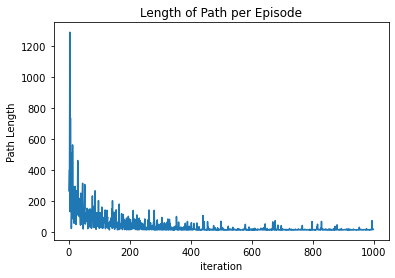

In [248]:
plt.plot(path_length_episode)
plt.title('Length of Path per Episode')
plt.ylabel('Path Length')
plt.xlabel('iteration')

## Second Idea

In [249]:
def training_model(gamma,Learning_rate,exploration_probability,episode):
    Numer_of_states=10*10*1
    Number_of_action=4
    Q_Matrix = loadtxt('Q_func_init.csv', delimiter=',')
    path_length_episode = []
    rewards_per_episode = []
    for i in range(episode):
        state = env.reset()
        move=0
        reward=0
        done = False
        total_episode_reward = 0
        while not done:
            if random.uniform(0, 1) < exploration_probability:
                action = env.action_space.sample() 
            else:
                action = np.argmax(Q_Matrix[state]) 
            
            next_state, reward, done, info = env.step(action)
            
            if state == 45:
                  reward=0.8
            if state == 46:
                  reward=0.8
            if state == 36:
                  reward=0.8
            if state == 26:
                  reward=0.8
            if state == 16:
                  reward=0.8
            if state == 6:
                  reward=0.8
            if state == 5:
                  reward=0.8
            if state == 4:
                  reward=0.8
            if state == 3:
                  reward=0.8
            if state == 1:
                  reward=0.8
            if state == 1:
                  reward=0.8
                    
            if reward == -10 :
                next_state=44    
            previous_value = Q_Matrix[state, action]
            next_max = np.max(Q_Matrix[next_state])
            reward=reward-1
            new_value = (1 - Learning_rate) * previous_value + Learning_rate * (reward + gamma * next_max)
            Q_Matrix[state, action] = new_value  
            total_episode_reward = total_episode_reward + reward
            state = next_state
            move += 1
        rewards_per_episode.append(total_episode_reward)
        path_length_episode.append(move)  
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")    
    print("Training succesfully finished.\n")
    savetxt('Q_func.csv',Q_Matrix, delimiter=',')
    
    return path_length_episode,rewards_per_episode,Q_Matrix

In [250]:
path_length_episode,rewards_per_episode,Q_Matrix=training_model(gamma,Learning_rate,exploration_probability,1000)
episodes = 5
for _ in range(episodes):    
    state = env.reset()
    move=0
    penalties=0
    reward = 0
    done = False
    while not done:
        action = np.argmax(Q_Matrix[state])
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        if reward == -3:
            penalties += 1
        move += 1
    env._render()    
    print(f"Results after {episodes} episodes:")
    print(f"Path Length: {move}")
    print(f"Number of Penalty: {penalties}")

Episode: 900
Training succesfully finished.

  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
Results after 5 episodes:
Path Length: 12
Number of Penalty: 0
  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    

  웃   .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
Results after 5 episodes:
Path Length: 12
Number of Penalty: 0


Text(0.5, 0, 'iteration')

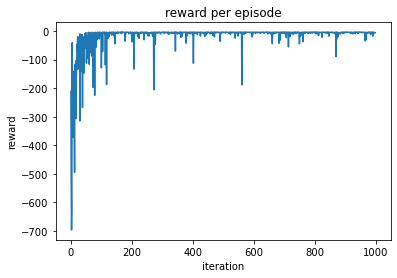

In [251]:
plt.plot(rewards_per_episode)
plt.title('reward per episode')
plt.ylabel('reward')
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

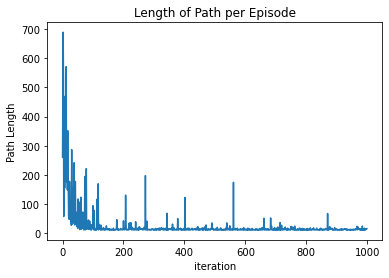

In [252]:
plt.plot(path_length_episode)
plt.title('Length of Path per Episode')
plt.ylabel('Path Length')
plt.xlabel('iteration')